## Домашнаяя работа 6: Байес на практике и другие оксюмороны

### Цель
Используя фреймворк байесовских методов и библиотеку PyMC3 вам предстоит построить интерпретируемую вероятностную модель и решить задачу регрессии для заданного датасета.

### Описание данных
Датасет доступен по ссылке: https://www.kaggle.com/c/house-prices-advanced-regression-techniques



### Библиотеки и константы

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#Константы
RANDOM_SEED = 42

### Предобработка данных

In [3]:
data_train = pd.read_csv("/content/drive/MyDrive/house-prices-advanced-regression-techniques/train.csv")
data_test = pd.read_csv("/content/drive/MyDrive/house-prices-advanced-regression-techniques/test.csv")

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
data_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
def get_missing_values(dataframe):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

In [7]:
get_missing_values(data_train)

              n_miss  ratio
PoolQC          1453  99.52
MiscFeature     1406  96.30
Alley           1369  93.77
Fence           1179  80.75
MasVnrType       872  59.73
FireplaceQu      690  47.26
LotFrontage      259  17.74
GarageType        81   5.55
GarageYrBlt       81   5.55
GarageFinish      81   5.55
GarageQual        81   5.55
GarageCond        81   5.55
BsmtExposure      38   2.60
BsmtFinType2      38   2.60
BsmtQual          37   2.53
BsmtCond          37   2.53
BsmtFinType1      37   2.53
MasVnrArea         8   0.55
Electrical         1   0.07


Я решил просто дропнуть колонки с пропусками, за исключением Electrical и MasVnrArea. В этих колонках мало пропусков. Поэтому для них я простоу удалю записи с пропусками.

In [8]:
na_columns = data_train.columns[data_train.isna().any()].tolist()
na_columns.remove('Electrical')
na_columns.remove('MasVnrArea')
na_columns

['LotFrontage',
 'Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [9]:
data_train = data_train.drop(na_columns, axis=1)
data_train = data_train.dropna()

data_test = data_test.drop(na_columns, axis=1)
data_test = data_test.dropna()

In [10]:
get_missing_values(data_train)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [11]:
get_missing_values(data_test)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


### Кодировка значений
Закодируем строковые колонки, а числовые стандартизируем.

In [12]:
TARGET = 'SalePrice'

In [13]:
def prepare_data(X_train, X_test):
  num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
  cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

  preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ])

  X_train_processed = preprocessor.fit_transform(X_train)
  X_test_processed = preprocessor.transform(X_test)

  # Получение имен признаков после OneHotEncoder
  # if len(cat_cols) > 0:
  #     ohe = preprocessor.named_transformers_['cat']
  #     cat_feature_names = ohe.get_feature_names_out(cat_cols)

  #     feature_names = list(num_cols) + list(cat_feature_names)
  # else:
  #     feature_names = num_cols

  # X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
  # X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

  return X_train_processed, X_test_processed

In [14]:
data_train = data_train.set_index('Id')
data_test = data_test.set_index('Id')

In [15]:
X_train = data_train.drop(TARGET, axis=1)
y_train = data_train[TARGET]

In [16]:
get_missing_values(data_test)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [17]:
X_train, X_test = prepare_data(X_train, data_test)

In [18]:
X_train.shape

(1451, 221)

In [19]:
X_test.shape

(1432, 221)

In [20]:
y_train.shape

(1451,)

### Построение модели


In [21]:
y_train_array = np.ravel(y_train)

In [22]:
with pm.Model() as linear_regression_model:
    # X_data = pm.Data("X_data", X_train)
    y_data = pm.Data("y_data", y_train_array)

    # Априорные распределения
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + pm.math.dot(X_train, slope)

    # Правдоподобие
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_data)

    # Сэмплирование
    trace = pm.sample(2000, return_inferencedata=True)

Output()

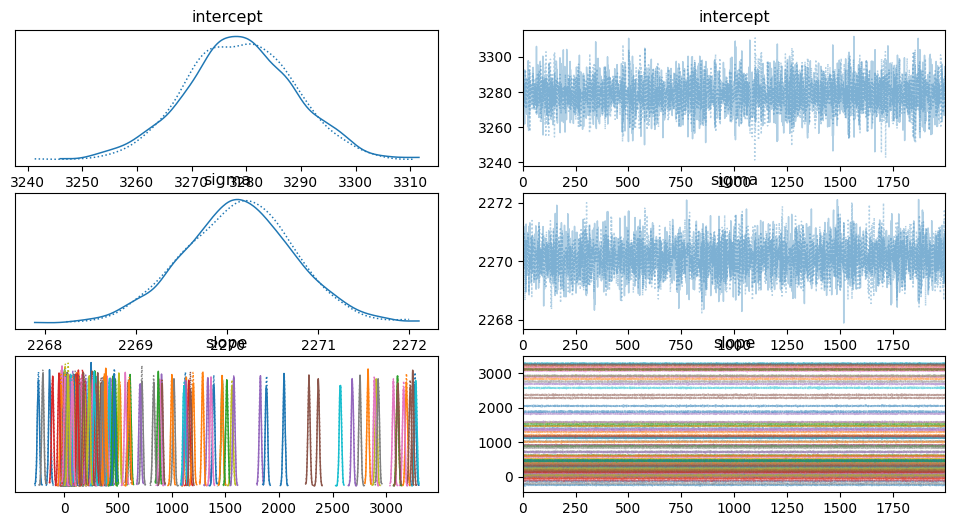

In [23]:
# Визуализация результатов
az.plot_trace(trace)
plt.show()

In [24]:
print(az.summary(trace, hdi_prob=0.95))

                mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
intercept   3278.814   9.875  3260.261   3298.698      0.119    0.186   
sigma       2270.131   0.600  2268.934   2271.280      0.006    0.009   
slope[0]    -137.716  10.054  -157.291   -117.786      0.108    0.215   
slope[1]     515.721   9.886   496.431    534.831      0.101    0.181   
slope[2]    1471.485  10.052  1452.886   1492.884      0.107    0.188   
...              ...     ...       ...        ...        ...      ...   
slope[216]     5.041   9.915   -12.624     24.889      0.110    0.177   
slope[217]    23.391   9.822     4.740     43.044      0.125    0.179   
slope[218]    34.718   9.680    16.858     55.469      0.103    0.187   
slope[219]  2573.342  10.063  2554.592   2593.879      0.110    0.220   
slope[220]   465.358  10.014   445.597    484.170      0.102    0.219   

            ess_bulk  ess_tail  r_hat  
intercept     6930.0    2686.0    1.0  
sigma         8508.0    3305.0    1.0  
slo

Я признаться не понял как оценить модель. Погуглил в эту сторону у судя по всему привычные метрики вроде RMSE b МАЕ для моделей pymc не в почете. Люди используют LOO. Но примеры, котоыре я встречал либо не работают, либо что-то выдают не я не понимаю как это интерпритировать. Тем не менее добавил работающий пример.  

In [25]:
with linear_regression_model:
    pm.compute_log_likelihood(trace)

Output()

In [26]:
loo = az.loo(trace)
loo

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,0
elpd_loo,-2593167.886985
se,107602.083415
p_loo,6401.412226
n_samples,4000
n_data_points,1451
warning,True
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.7


### Предсказание


In [27]:
with linear_regression_model:
    X_data = pm.Data("X_data", X_train)

    mu_new = intercept + pm.math.dot(X_data, slope)
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['y'], return_inferencedata=False)

Output()

In [28]:
p_test_pred = posterior_predictive["y"].mean()

In [29]:
p_test_pred

np.float64(64170.65733240615)

In [30]:
with linear_regression_model:
    pm.set_data({'X_data': X_test})
    posterior_predictive_new = pm.sample_posterior_predictive(trace, var_names=['y'], return_inferencedata=False)

Output()

In [31]:
# Точечные предсказания (среднее по апостериорному распределению)
y_pred = posterior_predictive_new['y'].mean(axis=0)

# 95% доверительный интервал
hdi = az.hdi(y_pred, hdi_prob=0.95)

<ipython-input-31-3dd39c6970d7>:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred, hdi_prob=0.95)


In [32]:
print("\nДоверительный интервал (95%) для предсказанных значений:")
print(hdi)


Доверительный интервал (95%) для предсказанных значений:
[[74763.00170952 80936.66536767]
 [61641.30829766 67821.22904464]
 [75039.73829291 81074.01743618]
 ...
 [65678.93348642 71939.79295181]
 [51119.77630659 57452.17759199]
 [61751.31926788 68154.96847637]]


### Вывод
Построили байесовскую модель линейной регрессии и с помощью ее получили предсказание.
К сожалению вытащить предсказанные результаты или как-то оценить модель я не могу потому-то не нашел как это сделать.  
На работу ушел примерно рабочий день. Эту же задачу с sklearn можно решить примерно за час.  
Могу сделать вывод что pymc невероятно полезный инструмент.